# Лабораторная работа №2
# Моделирование работы касс супермаркета при помощи библиотеки SimPy

### Задача
Смоделировать работу супермаркета по следующим условиям:
* Поток клиентов имеет распределение Пуассона с интенсивностью l = 3 человека в минуту
* Средний чек составляет 200±50 рублей
* Время обслуживания клиента t_service = 2 минуты
* Если все кассы заняты, то клиент встаёт в самую короткую очередь
* Если очередь в каждой кассе 5 и более человек, клиент покидает магазин
* Кассы работают до последнего клиента

Построить график доходов и недополученных доходов магазина в зависимости от числа касс.
(Определить оптимальное число кассиров, если стоимость содержания кассы 100 т.р. в месяц.)

Скорректировать программу так, чтобы задать различную интенсивность потока клиентов в разное время дня.

### Импорт требуемых библиотек

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import simpy

### Глобальные переменные для накопления статистики

In [2]:
q_len = 0  # Длина очереди (общее число человек во все кассы)
t_service = 2  # Время обслуживания - 2 минуты
n_kass = 3  # Число касс
sum_revenue = 0  # Суммарный доход магазина
sum_loss = 0  # Недополученный доход
client_loss = 0  # Число ушедших клиентов

### Определим модель поведения клиента

In [3]:
def client(env, kassa, start_time):
    global q_len
    global t_service
    global n_kass
    global sum_revenue
    global sum_loss
    global client_loss
    money = 150 + 100 * np.random.random()  # Сколько денег планирует потратить клиент
    # Начинаем симуляцию с момента прихода
    yield env.timeout(start_time)
    # print(f"Клиент пришёл в {env.now}")
    with kassa.request() as req:
        results = yield req | env.timeout(5)  # Клиент ждёт 5 минут и уходит
        if req in results:
            yield env.timeout(t_service)  # Время обслуживания
            sum_revenue += money  # Клиент оставляет свои деньги в магазине
        else:
            sum_loss += money  # Клиент уходит вместе с деньгами
            client_loss += 1
#    if q_len / n_kass < 5:  # Если очередь в каждую кассу не превышает 5 человек,
#        q_len +=1           # то клиент встаёт в очередь
#        # Занимаем ресурс "Касса"
#        with kassa.request() as req:
#            yield req  # Ждём пока касса не освободится
#            # print(f"Начало обслуживания в {env.now}")
#            q_len -= 1
#            yield env.timeout(t_service)  # Время обслуживания
#            # print(f"Клиент ушёл в {env.now}")
#            sum_revenue += money  # Клиент оставляет свои деньги в магазине
#    else:
#        sum_loss += money  # Клиент уходит вместе с деньгами
#        client_loss += 1

### Запуск моделирования

In [4]:
revenue = []
losses = []
client_losses = []
kass_num = [x+1 for x in range(10)]
for i in kass_num:
    n_kass = i  # Для числа касс от 1 до 10 выполним симуляцию
    print(f"Симуляция для {n_kass} касс")
    sum_revenue, sum_loss, client_loss, q_len = 0, 0, 0, 0  # Обнулим счётчики
    
    env = simpy.Environment()  # Создадим окружение SimPy
    kassa = simpy.Resource(env, capacity=n_kass)  # Добавим в окружение кассы
    l = 3  # Интенсивность потока клиентов равна 3
    sim_time = 720  # Время симуляции - 60 * 12 = 720 минут
    # Определим число пришедших клиентов по закону Пуассона
    # client_num = np.random.poisson(l, sim_time)
    client_num = list(np.random.poisson(0.1, 120))
    client_num += list(np.random.poisson(4, 120))
    client_num += list(np.random.poisson(1, 180))
    client_num += list(np.random.poisson(5, 240))
    client_num += list(np.random.poisson(1, 60))
    # Добавим клиентов в окружение для симуляции с учётом времени их прихода
    for t in range(sim_time):  
        for j in range(client_num[t]):
            env.process(client(env, kassa, t))
    # Выполним симуляцию и сохраним полученные результаты
    env.run()
    revenue.append(sum_revenue)
    losses.append(sum_loss)
    client_losses.append(client_loss)

Симуляция для 1 касс
Симуляция для 2 касс
Симуляция для 3 касс
Симуляция для 4 касс
Симуляция для 5 касс
Симуляция для 6 касс
Симуляция для 7 касс
Симуляция для 8 касс
Симуляция для 9 касс
Симуляция для 10 касс


### Построить графики и сделать выводы

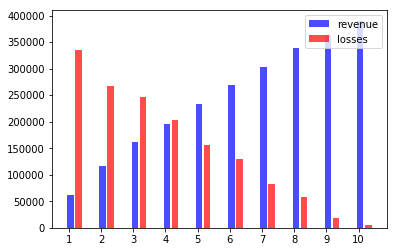

In [5]:
# Построим столбчатую диаграмму доходов и упущеной выгоды магазина
xs = range(len(kass_num))
plt.bar([x + 0.05 for x in xs],  # Координаты x стобцов
        revenue,  # Высота столбца соответствует полученным одходам
        width = 0.2, color = 'blue', alpha = 0.7, label = 'revenue',
        zorder = 2)
plt.bar([x + 0.3 for x in xs], losses,
        width = 0.2, color = 'red', alpha = 0.7, label = 'losses',
        zorder = 2)
plt.xticks(xs, kass_num)
plt.legend(loc='upper right')
plt.show()